# Import Libaries

In [1]:
# import libraries 
import os
import tensorflow as tf
import numpy as np
import time
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import pickle

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential #, load_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Data Loading

[dataset](https://vis-www.cs.umass.edu/lfw/)

`ImageDataGenerator` is a class provided by TensorFlow allows you to perform real-time data augmentation and preprocessing on image data during the model training process. It's commonly used in tasks such as image classification, object detection, and face recognition where preprocessing and augmentation can improve model performance and robustness.

In [2]:
train_images = r"Face Images/Train"
test_images = r"Face Images/Test"

''' 
1. shear_range: Shear transformation perturbs the coordinates of the image in a direction perpendicular to the axis of distortion. It's a type of affine transformation where each point in the image is shifted by a distance proportional to its distance from an axis.
shear_range = 0.1 means that each image will be randomly sheared within the range [-0.1, 0.1]. This introduces small distortions in the shape of objects in the images, which can help in training a more robust model by exposing it to variations in object orientations.

2. zoom_range: Zoom transformation randomly zooms into the image. zoom_range=0.1 means that each image will be randomly zoomed in or out within the range [1-0.1, 1+0.1]. This augmentation technique helps the model generalize better by training it on different scales of the same object.
3. horizontal_flip:  Horizontal flipping randomly flips images horizontally. horizontal_flip=True means that each image has a 50% chance of being flipped horizontally. This augmentation can help the model learn invariant features and improve its ability to generalize to unseen data.
'''
train_gen = ImageDataGenerator(
    shear_range=0.1, 
    zoom_range=0.1,
    horizontal_flip=True
)

# No transformations are made on the test data
test_gen = ImageDataGenerator()

''' 
- This method of ImageDataGenerator takes the path to a directory and generates batches of augmented data from the images found in that directory
- All images will be resized to 224x224 pixels. This is important because most deep learning models require input images to be of the same size.
- 32 number of images to be yielded from the generator per batch. atch processing is used to make the training process more efficient and to fit within the memory constraints of the hardware.
- 'categorical' means that the labels are returned as one-hot encoded arrays.'categorical' means that the labels are returned as one-hot encoded arrays.'categorical' means that the labels are returned as one-hot encoded arrays. This is useful for multi-class classification problems.
'''
# Generating training data
training_data = train_gen.flow_from_directory(
    train_images, 
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical'
)

# generating test data
testing_data = test_gen.flow_from_directory(
    test_images, 
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'categorical'
)


Found 247 images belonging to 16 classes.
Found 64 images belonging to 16 classes.


## Data Visualization

1. Training Data

In [3]:
def visualization(data, label):

    # Get a batch of images
    x_batch, y_batch = next(data)  

    # Plot the images in the batch
    fig, axes = plt.subplots(3, 10, figsize=(20, 6))
    axes = axes.flatten()
    for img, ax in zip(x_batch, axes):
        ax.imshow(img.astype(np.uint8))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    # Data distribution visualization
    class_labels = list(data.class_indices.keys())
    class_counts = data.labels

    plt.figure(figsize=(15, 6))
    bars  = plt.hist(class_counts, bins=len(class_labels), edgecolor='black')
    
    # Adding the count on top of each bar
    for bar in bars[2]:  # bars[2] contains the bar rectangles
        height = bar.get_height()
        plt.annotate('{}'.format(int(height)),  # Adding the text label
                    xy=(bar.get_x() + bar.get_width() / 2, height),  # Positioning at the center top of the bar
                    xytext=(0, 3),  # Offset for the text
                    textcoords='offset points',
                    ha='center', va='bottom')
    plt.xticks(range(len(class_labels)), class_labels, rotation=30)
    plt.xlabel('Class Labels')
    plt.ylabel('Number of Images')
    plt.title(f'Distribution of {label} Class Labels ')
    plt.tight_layout()
    plt.show()

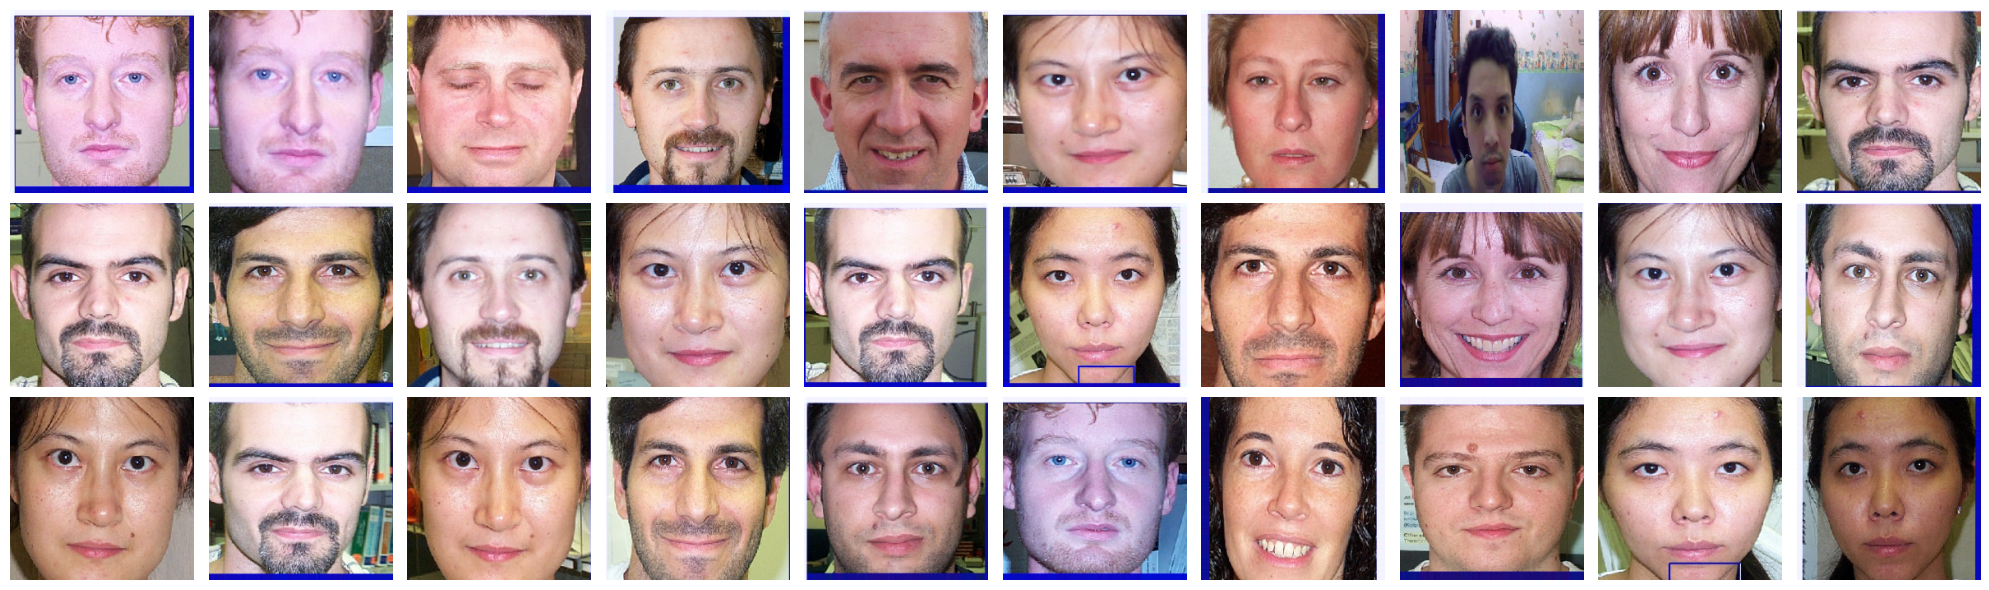

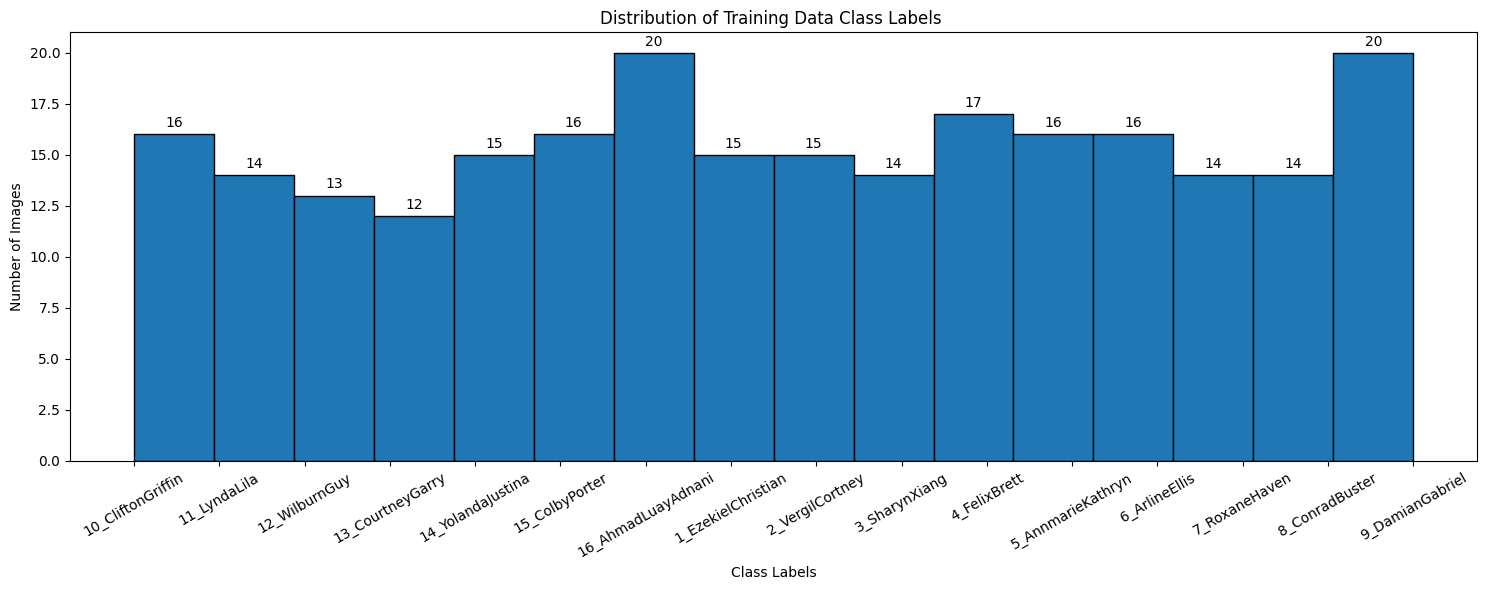

In [4]:
visualization(training_data, 'Training Data')

2. Testing Data

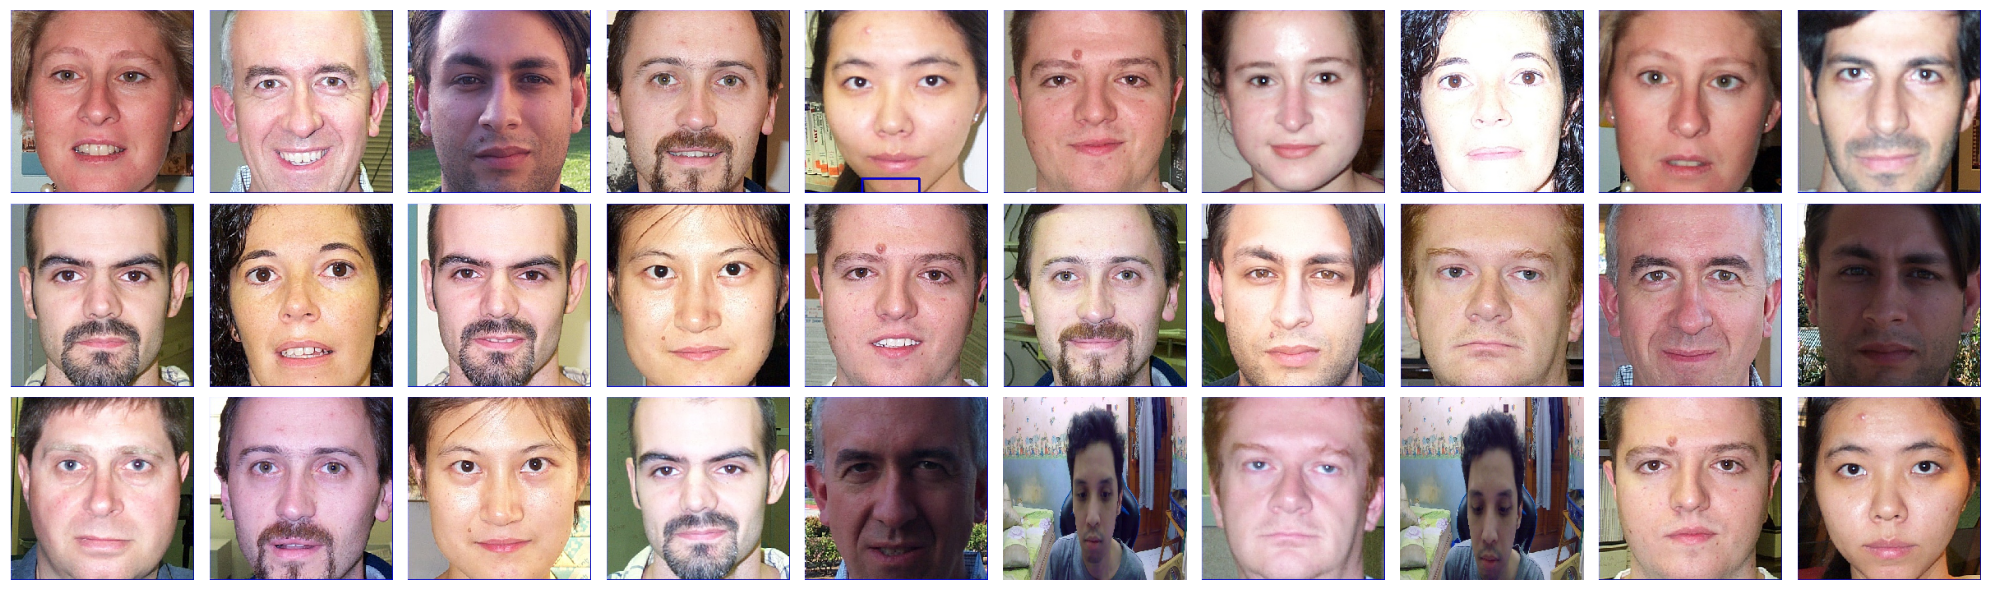

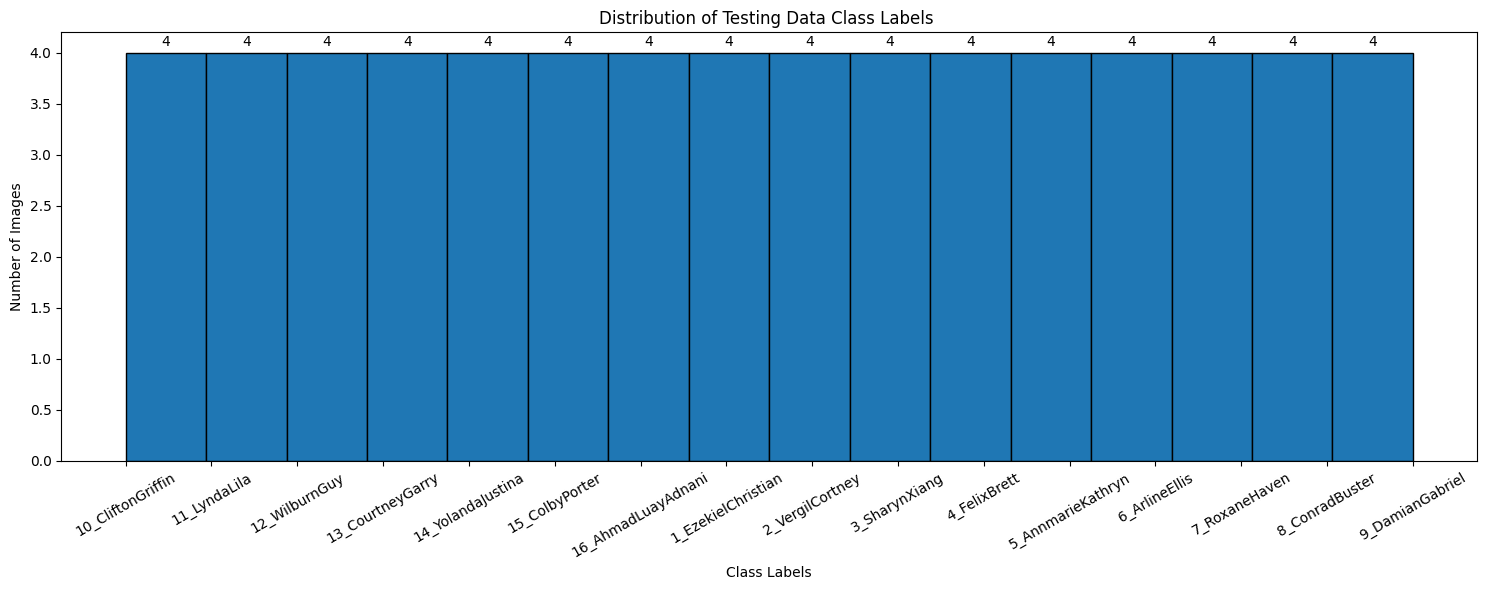

In [5]:
visualization(testing_data, 'Testing Data')

In [6]:
# training_data have numeric tag for each face
Train_class = training_data.class_indices

# lets store them in a dictionary with swap for future reference
Result_class = {}
for value_tag, face_tag in zip(Train_class.values(),Train_class.keys()):
    Result_class[value_tag] = face_tag

    
# use pickle to save the mapping's
with open(r"Face Images/ResultMap.pkl",'wb') as Final_mapping:
    pickle.dump(Result_class,Final_mapping)

print("Mapping of Face and its numeric value",Result_class)

Output_Neurons=len(Result_class) # The Number of output neurons in softmax

Mapping of Face and its numeric value {0: '10_CliftonGriffin', 1: '11_LyndaLila', 2: '12_WilburnGuy', 3: '13_CourtneyGarry', 4: '14_YolandaJustina', 5: '15_ColbyPorter', 6: '16_AhmadLuayAdnani', 7: '1_EzekielChristian', 8: '2_VergilCortney', 9: '3_SharynXiang', 10: '4_FelixBrett', 11: '5_AnnmarieKathryn', 12: '6_ArlineEllis', 13: '7_RoxaneHaven', 14: '8_ConradBuster', 15: '9_DamianGabriel'}


# Model Training

In sequential neural networks, we create the model layer-by-layer. Sharing of layers or branching of layers and multiple inputs or outputs are not allowed. So in this model, we can see from the flow chart that sequential model is basically a series model.

In [7]:
# Sequential model
seed = 50
clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

Model = Sequential()

## First layer

-  **16** filters or output channels. This is the number of feature maps the convolutional layer will produce.
- **5x5** kernel (The dimensions of the convolutional filter) will be applied to the input data.
- A stride (step size the filter moves across the input image) of **(1,1)** means the filter moves one pixel at a time both horizontally and vertically.
- The shape of the input data: the input images are **224x224 pixels with 3 color channels (RGB).**
- The activation function applied to the output of this layer is **ReLU**. ReLU (Rectified Linear Unit) introduces non-linearity to the model.

In [8]:
# First Layer
Model.add(Conv2D(16, kernel_size=(5,5), strides=(1,1), input_shape = (224,224,3),activation='relu'))

f:\Projects\Facial-Recognition-App\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Second Layer

- A **2x2** pooling window is used, which means it will down-sample the input by taking the maximum value from each 2x2 block of values.

In [9]:
# Second Layer
Model.add(MaxPool2D(pool_size=(2,2)))

## Third layer

-  **32** filters or output channels. This is the number of feature maps the convolutional layer will produce.
- **3x3** kernel (The dimensions of the convolutional filter) will be applied to the input data.
- A stride (step size the filter moves across the input image) of **(1,1)** means the filter moves one pixel at a time both horizontally and vertically.
- The activation function applied to the output of this layer is **ReLU**. ReLU (Rectified Linear Unit) introduces non-linearity to the model.


In [10]:
# Third Layer
Model.add(Conv2D(32,kernel_size=(3,3),strides=(1,1),activation='relu'))

## Fourth Layer
- A **2x2** pooling window is used, which means it will down-sample the input by taking the maximum value from each 2x2 block of values. 

In [11]:
# Fourth Layer
Model.add(MaxPool2D(pool_size=(2,2)))

## Fifth Layer

-  **Flatten**: This layer converts the 2D feature maps from the previous layer into a 1D vector. This is necessary before feeding the data into the fully connected (Dense) layers.

In [12]:
# Fifth Layer
Model.add(Flatten())

## Sixth Layer

- **64**  neurons in this fully connected layer.
- **Relu** activation function

In [13]:
# Sixth Layer
Model.add(Dense(64,activation='relu'))

## Seventh Layer

- The number of output neurons, which typically corresponds to the **number of classes** in the classification task. 
- **Softmax** activation function. Softmax is used for multi-class classification problems, as it converts the outputs to a probability distribution.

In [14]:
# Seventh Layer
Model.add(Dense(Output_Neurons,activation='softmax'))

## Model Compilation

The `compile` method configures the model for training. It specifies the loss function, optimizer, and metrics to monitor during training.

- The `loss` function measures how well the model's predictions match the true labels. The goal of training is to minimize this loss. **Categorical Crossentropy** is used for multi-class classification problems where each sample can belong to one out of many possible categories. It calculates the difference between the true labels and the predicted probabilities.

- The `optimizer` updates the model's weights based on the gradients of the loss function with respect to the weights. **Adam** adjusts the learning rate for each parameter dynamically, making it particularly effective and easy to use for various types of neural networks.

- `Metrics` are used to evaluate the performance of the model during training and testing. They do not affect the training process but provide insights into how well the model is performing. **Accuracy** is the ratio of the number of correct predictions to the total number of predictions.

In [15]:
Model.compile(loss='categorical_crossentropy',optimizer = 'adam',metrics = ['Accuracy'])
Model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 220, 220, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 108, 108, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 93312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     5,972,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,978,928 (22.81 MB)

 Trainable params: 5,978,928 (22.81 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

The `EarlyStopping` callback is used to stop the training process when the monitored metric (usually the validation loss or accuracy) stops improving. This can help prevent overfitting and reduce the training time by stopping the training process once the model has sufficiently learned and further training would not result in significant improvements.

- **0.005** is the minimum change in the monitored metric (e.g., validation loss) to be considered as an improvement.
- If the monitored metric does not improve for **5** consecutive epochs, the training will be stopped.
- Epoch = **50**, This parameter specifies the number of times the entire training dataset will be passed through the model during training.


## 

In [16]:
call = EarlyStopping(
                    min_delta=0.005,
                    patience=5,
                     verbose=1
                    )
StartTime=time.time()


history = Model.fit(training_data,
          epochs = 50,
          validation_data=testing_data,
                   callbacks=call)

Endtime = time.time()
print('Total Training Time taken: ',round((Endtime-StartTime)/60),'Minutes')

Epoch 1/50


f:\Projects\Facial-Recognition-App\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 708ms/step - Accuracy: 0.0602 - loss: 1081.3477 - val_Accuracy: 0.0625 - val_loss: 194.7843
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 474ms/step - Accuracy: 0.0844 - loss: 164.2263 - val_Accuracy: 0.0625 - val_loss: 19.2186
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 503ms/step - Accuracy: 0.1231 - loss: 10.6900 - val_Accuracy: 0.2500 - val_loss: 2.3479
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 389ms/step - Accuracy: 0.2404 - loss: 2.3278 - val_Accuracy: 0.2812 - val_loss: 2.1329
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 335ms/step - Accuracy: 0.3287 - loss: 2.2386 - val_Accuracy: 0.4062 - val_loss: 1.9613
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 385ms/step - Accuracy: 0.4174 - loss: 1.9424 - val_Accuracy: 0.5312 - val_loss: 1.4450
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 371ms/step - Accuracy: 0.6723 - loss: 1.1872 - val_Accuracy: 0.7812 - val_loss: 0.7923
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 364ms/step - Accuracy: 0.8278 - loss: 0.5117 - val_Accuracy: 0.9062 - val_loss:

# Model Evaluation

In [17]:
def plot_training(history):
    fig, ax = plt.subplots(1, 2, figsize=(30, 10))
    fig.suptitle('Sequential Method on Training Data Evaluation', fontsize=25, weight='bold')

    # Plot Training and Validation accuracy
    plt.subplot(1, 2, 1)
    plt.title("Training and Validation Accuracy", fontsize=12)
    plt.plot(history.history['Accuracy'], label="Training Accuracy")
    plt.plot(history.history['val_Accuracy'], label="Validation Accuracy")
    plt.ylabel("accuracy", fontsize=12)
    plt.legend()
    plt.grid(linestyle='--')

    # Plot Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.title("Training and Validation Losses", fontsize=12)
    plt.plot(history.history['loss'], label="Training Loss")
    plt.plot(history.history['val_loss'], label="Validation Loss")
    plt.ylabel("Loss", fontsize=12)
    plt.legend()
    plt.grid(linestyle='--')

    # Show the plots
    plt.style.use('default')
    plt.show()

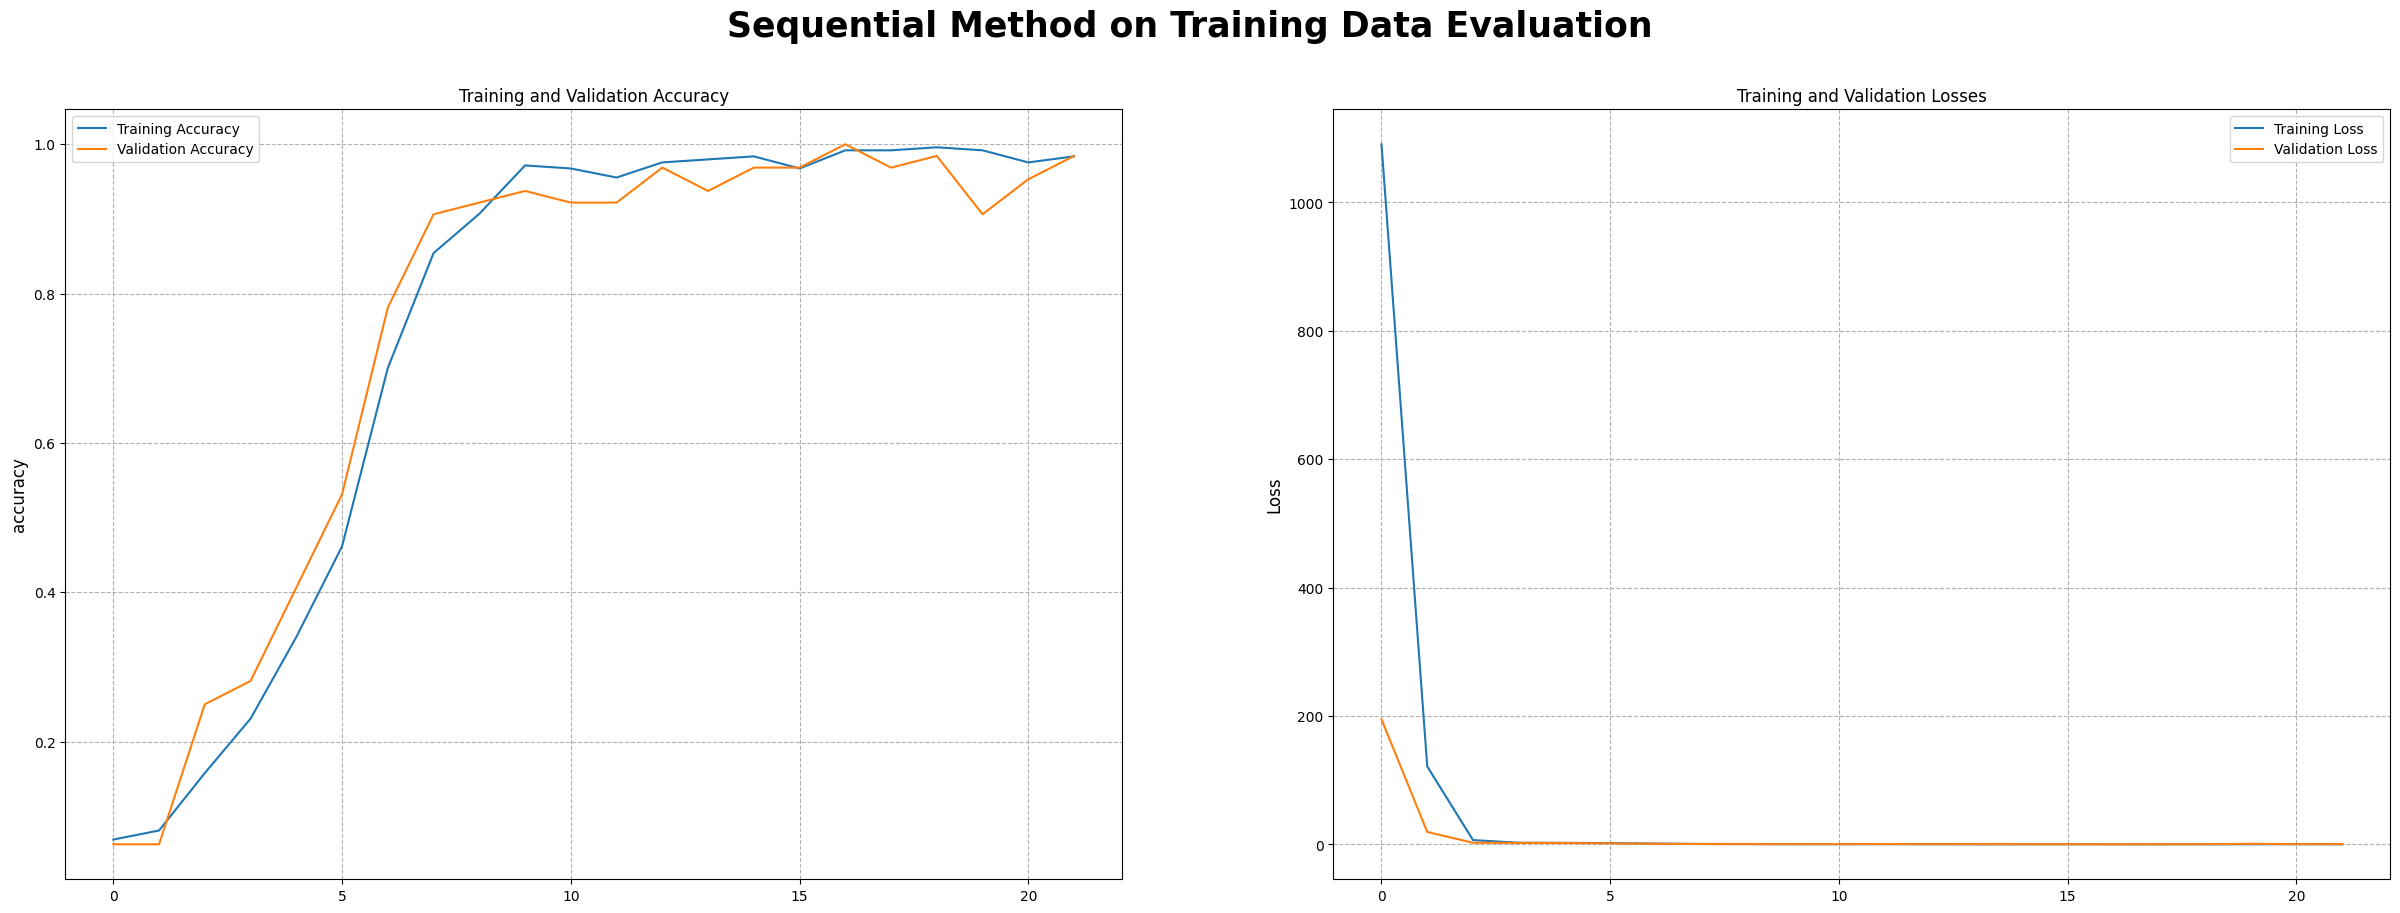

In [18]:
plot_training(history)


# Model Saving

In [19]:
# Define the directory to save the model
model_directory = 'model'

# Create the directory if it does not exist
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

# Define the path to save the model
model_path = os.path.join(model_directory, 'model.h5')

# Save the model
Model.save(model_path)